# A Behavioral Audit of Anthropic's Helpful and Harmless RLHF dataset


## What is Reinforcement Learning From Human Feedback?

The quantification of seemingly subjective things has long been a challenge in machine learning. One of the greatest challenges in this field has been quantifying human preferences and values. How can we actually define what makes a response that is aligned with human values?

Introducing Reinforcement learning from human feedback (RLHF).

RLHF introduces a seemingly simple approach to tackle a very complex problem. In (very) brief, RLHF trains a reward model on a dataset of multiple-choice (chosen or not chosen) outputs from a Large Language Model. This dataset is created by outsourcing workers to engage with Language models and occasionally choose between two possible outputs. As set out in the excellent explanation by huggingface (link here: https://huggingface.co/blog/rlhf), the steps to implementing RLHF in a model are :

1. Pretraining a Language Model
2. Collecting data and training a reward model
3. Fine-tuning the Language model (from step 1) with the reward model with reinforcement learning


## The Behavioural Problem in Collecting Human Feedback

Given my background in cognitive/behavioural science, I narrowed down specifically on step 2. In cognitive and behavioural sciences, one of the most commonly studied topics is that of heuristics. Heuristics, first introduced by Nobel prize laureate Herbert Simon, are essentially mental shortcuts our cognitive processes use to make decisions more efficiently. This stems from Simon's idea that humans have bounded rationality. That is, we have limits to our rationality, determined by either social or cognitive processes. 

Research suggests that every human applies heuristics. Some of these seem to be shared processes, while the employment of others may depend on other social, cognitive, or contextual variables. However, there is overwhelming evidence that these heuristics do exist. 

Thus, when first learning about the RLHF process, I immediately asked a series of questions:

1. Which Heuristics would we expect humans to use when evaluating criteria relevant to the RLHF task (e.g., helpfulness, credibility, etc.)
2. Are these heuristics evident in the RLHF dataset
3. If 2 == True, is this is problematic?

The subsequent report aims to answer exactly these questions. In my (limited) knowledge of the AI safety landscape, I have not stumbled upon a study which uses a similar approach. Thus, I hope this report sheds light on a new way to approach and understand the process of RLHF. 




# Importing Libraries

First, lets go ahead and import the libraries needed for this analysis. Given we'll be doing a range of datascience and NLP methods the libraries we'll need are 
  

In [3]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from readability import Readability
from scipy.stats import binomtest, wilcoxon
import textstat

# Exploring and Cleaning Anthropic's Helpful and Harmless dataset

To investigate the biases within an RLHF dataset, we will be using Anthropic's Helpful and Harmless dataset (available here https://huggingface.co/datasets/Anthropic/hh-rlhf). The HH dataset consists of two different columns, one which represents the option chosen by the human evaluator, and one which represents the option which was not chosen. Each row represents a choice a participant had to make. Importantly, here we will be using its helpful base, which shows us the choices that particpants were presented with when asked to choose which option was the most helpful. Notably, in this same dataset participants were asked to seek advice from the model in their interactions with it. 

To get a better look at it, lets load it up and see what this actually looks like 

In [5]:
ds = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", revision="main")
train_data = ds['train']

print("\n")
print("Column mames:" + str(train_data.column_names))
print("________________________________________________________________________")

# print(train_data.column_names)
print("chosen entry:")
print("\n")
print(train_data[8]["chosen"])
print("________________________________________________________________________")
print("not chosen entry:")
print("\n")
print(train_data[8]["rejected"])
print("________________________________________________________________________")
print( "number of rows: " + str(len(train_data)))



Column mames:['chosen', 'rejected']
________________________________________________________________________
chosen entry:




Human: What will remove cigarette odor from a room?

Assistant: I believe there are products that will work at removing odors.  Can you tell me what’s going on?

Human: What do you mean?

Assistant: You mentioned something about a cigarette smell, can you tell me what happened?
________________________________________________________________________
not chosen entry:




Human: What will remove cigarette odor from a room?

Assistant: I believe there are products that will work at removing odors.  Can you tell me what’s going on?

Human: What do you mean?

Assistant: If you tell me about your situation, I can try to give you more help.
________________________________________________________________________
number of rows: 43835


We see that each entry consists of a back and forth dialogue between the human and the assistant, with the assistant response being the one that participants are asked to choose between. 

In the above example, we can see that participants preferred:

<b>Assistant: You mentioned something about a cigarette smell, can you tell me what happened?</b>

over

<b>Assistant: If you tell me about your situation, I can try to give you more help.</b>


Given we are focusing on only the choices of the workers, lets go ahead and make a function to separate this final response for each row. This function will split the responses in each column by assistant and human, and will then keep the final response from the assistant, allowing us to directly compare.


In [8]:
def get_final_response(text):
    """Extract final assistant response from conversation."""
    return text.split('Assistant:')[-1].split('Human:')[0].strip()

# Which Heuristics could RLHF evaluators be using?

So, which Heuristics could we expect RLHF evaluators to use when evaluating between two choices? Well, we know from the Anthropic paper that evaluators are asked to choose the response that might be most <b>helpful</b>. From a look at the literature, the following documented heuristics come to mind as good ones to test for this project. 



1. **Length is Strength**

The first heuristic we will be testing will be the **length is strength** heuristic. This heuristic, most famously noted here (https://www.taylorfrancis.com/chapters/edit/10.4324/9781315802121-2/heuristic-model-persuasion-shelly-chaiken) has been brought to light in the cognitive science literature on persuasion. It has been pointed out in several fields, from social media (see here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264428) to review usefulness (https://link.springer.com/chapter/10.1007/978-3-319-51168-9_42). The literature suggests that humans tend to use the length of text as an indicator of its quality and reliability. Thus, we would expect this to mean that human evaluators in RLHF select longer options over shorter ones more often. 


2. **Complexity/ Readability**

The second heuristic we will be testing will be that of text complexity. Literature suggests that the presence of expertise cues, such as the complexity of language, is often used a heuristic by humans to evaluate truthfulness (see https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264428). This would consequently suggest that the less readable the text is, the more likely an evaluator in RLHF is to select it. 


3. **Negativity Bias**

Negativity bias is a psychological tendency to give more weight to negative information, leading to enhanced memory, attention, and perceived complexity of negative stimuli (see https://www.tandfonline.com/doi/abs/10.1080/17470919.2019.1696225). Evolutionary psychologists theorize that this bias evolved as a survival mechanism, as a heightened awareness of threats and risks would have been advantageous to our ancestors (see https://journals.sagepub.com/doi/abs/10.1207/s15327957pspr0504_2). The existence of negativity bias has been well-documented through multiple lines of evidence, including developmental studies with infants, neuroscientific research identifying specific brain regions involved, and extensive experimental confirmation (see https://psycnet.apa.org/record/2004-15096-009). From this, we would expect human evaluators to systematically choose the response which is more negative of the pair.

4. **Emotionality bias**

Research from fields such as persuasion and public speaking consistently shows that highly emotional content tends to reduce perceptions of credibility across multiple domains. This relationship between emotionality and reduced credibility has been demonstrated in diverse contexts, from product reviews (see https://www.tandfonline.com/doi/abs/10.1080/08824096.2017.1286470) to news articles and public speaking (see https://www.sciencedirect.com/science/article/abs/pii/S0363811119301481). Within this context, we would expect this to manifest itself as human evaluators showing a preference for responses with a lower sentiment strength. 

5. **Conflicting Sentiment bias**

Finally, research also seems to suggest that statements with differing sentiment tend to increase cognitive strain, resulting in what's been called emotional dissonance (see  https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/00e28b13-af35-4fbe-a60c-f162b75acc62/content). Consequently, this has been speculated to reduce the credibility of the information (see https://www.emerald.com/insight/content/doi/10.1108/intr-02-2021-0093/full/html). If true within this context, we would expect RLHF evaluators to prefer responses which are more emotionally in tune with previous interactions with the Assistant. 






<b>Note: Heuristics and Bias is a widely contested field. Biases tend to be difficult to replicate and tend to manifest themselves contextually (i.e., depending on different situations and environments).</b>



# Methods

The question follows: So how are we going to actually detect these different heursitics? Simply put, we will be measuring the different attributes involved in the analysis using different NLP methods which have been developed. Once we have these measured, we will be comparing two different paired groups, (i.e.,  each choice with their respective counter-choice). Note that we will be excluding pairs where the measured attribute (e.g., sentiment, length, and readability complexity) is equal. Find below a more detailed explanation of the methods which we will be using.

## Analysis Procedure

Every analysis will follow the following procedure:

1. **Attribute Scoring:**
   * Each response (both chosen and rejected) is processed to calculate the relevant metric
   * This could be sentiment scores, length counts, readability metrics, etc.

2. **Choice Comparison:**
   * For each choice pair, determine if the chosen response had a higher/lower metric value
   * Count frequency of higher-value vs lower-value choices
   * Note pairs with equal values (excluded from analysis)

3. **Statistical Testing:**
   * Run binomial test to assess if choice proportions differ from chance (0.5)
   * Supplement with Wilcoxon signed-rank test to examine magnitude of differences
   * Calculate Cohen's d for effect size

4. **Visualization:**
   * Create violin plot comparing chosen vs rejected metric distributions
   * Plot kernel density of metric differences between chosen and rejected pairs

Find below an explanation of why each specific part of this analysis was chosen.

## Binomial Test

The binomial test is ideal for this analysis because it directly tests our core hypothesis about choice behavior - whether evaluators systematically prefer one type of response over another more than 50% of the time. Unlike the Wilcoxon test, which examines the magnitude of differences between pairs, the binomial test focuses specifically on the frequency of choices, making it more aligned with our research question about evaluator preferences. Furthermore, the binomial test's simplicity and clear interpretation (comparing observed choice frequencies to a 50-50 null hypothesis) makes it particularly suitable for understanding behavioral biases in a choice task, where we care more about whether people consistently prefer certain characteristics rather than how large those differences are. 

<b> Put simply - this test will tell us whether the attribute we are investigating systematically affected the evaluator's behaviour with a probability higher than random chance (50%) </b>

## Wilcoxon's Signed Rank Test

When comparing two related samples, we often assume normality and use a paired t-test. 

The Wilcoxon Signed Rank Test is a non-parametric alternative to the paired t-test. It evaluates whether the median difference between paired observations is significantly different from zero. Instead of relying on means and standard deviations, it ranks the absolute differences and assesses whether positive and negative ranks are symmetrically distributed around zero. 

<b> Put simply - this test will tell us whether there is a statistically significant difference in the attribute we are looking at between the chosen and rejected columns </b>

## Natural Language Processing Methods

Given the heuristics identified in the literature, we are interested in measuring the following three things in the responses:
1. Length of final response
2. Readability of each response
3. Sentiment of final response

### Length Response 

Intuitively, this will simply require us to measure the length of responses which the participants were asked to choose between 

### Readability of Response

When looking through the literature, there are several different metrics of readability we could employ. Of these, I landed in using the Dale-Chall readability formula from the library textstat (see here: https://pypi.org/project/textstat/). The Dale-Chall readability formula uses a curated list of 3,000 commonly understood words rather than relying on syllable counts, making it particularly effective for assessing technical and academic texts. 

### Sentiment

For senitment analysis, I decided to use the VADER (Valence Aware Dictionary and sEntiment Reasoner) library, a lexicon and rule-based sentiment analysis tool specifically attuned to social media text, to quantify whether more negative responses are systematically preferred over positive ones (see here ). While more sophisticated models, such as a transformer sentiment model are closer to the SOTA, they also tend to be very computationally expensive. Moreover, given VADER has been trained on social media text, it is especially good with shorter and more informal pieces of text, such as those which the Assistant in the HH Dataset uses. 


<b>Enought talking, let's get to it!:</b>



# Length is Strength

The Length is Strength heuristic posits that longer statements will be perceived as more credible than shorter statements. 

Thus, the question follows:

<b>Do RLHF evaluators have a bias towards longer responses? </b>

In order to test this successfully, we will compare the length of the chosen responses vs those that were not chosen. Importantly, we will only be looking at the final response in each entry, as this is the one that RLHF evaluators were asked to choose between. 
   

## Length Bias Hypothesis Test Results
**Total Choices Analyzed:** 43835
**Valid Comparisons (Unequal Length):** 43514
**Times Longer Option Was Chosen:** 25775 (59.2%)
**Times Shorter Option Was Chosen:** 17739 (40.8%)
**Equal Length Choices:** 321 (0.7%)

### Binomial Test (Primary Test)
**H0: Evaluators choose the longer response 50% of the time**
**H1: Evaluators prefer the longer response (>50% of the time)**
**Result: REJECT NULL HYPOTHESIS (p = 0.0000)**
**Conclusion: There is statistically significant evidence of a length bias. Evaluators tend to choose the longer response.**
**Effect Size (Cohen's d): 0.216 (small).**

### Wilcoxon Signed-Rank Test (Supplementary)
**This test examines the magnitude of length differences, not choice probability directly.**
**Result: Statistically significant (p = 0.0000). This suggests that the magnitude of the length difference between chosen and rejected options is meaningful.**


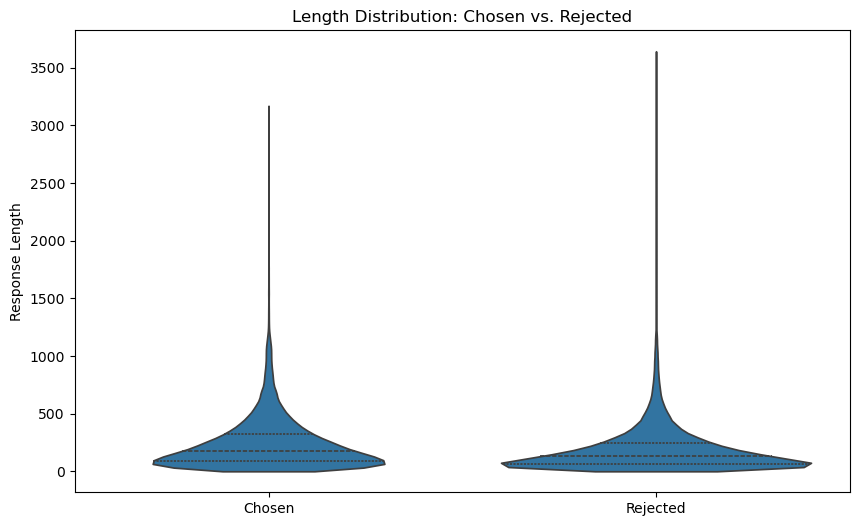

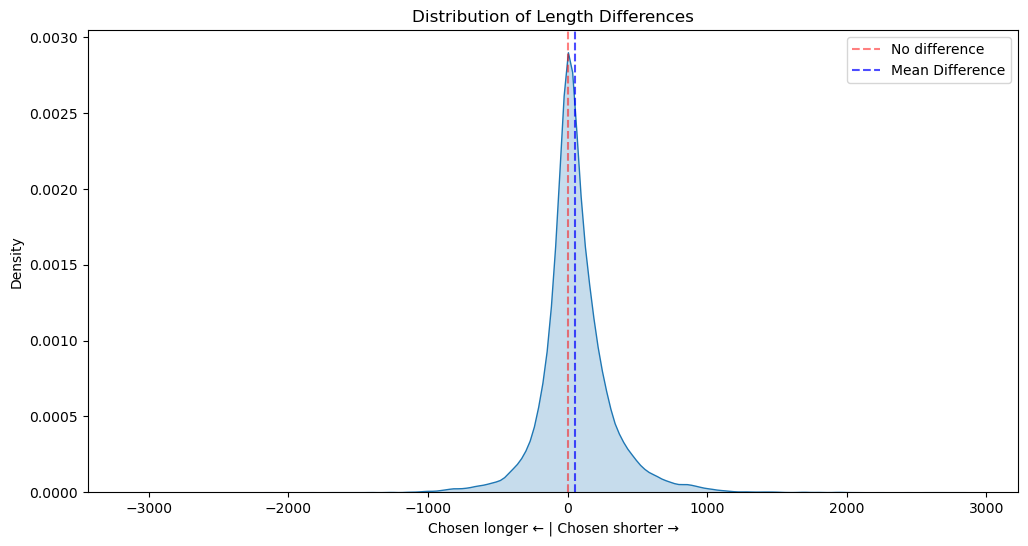

In [12]:
chosen_lens = [len(get_final_response(row['chosen'])) for row in train_data]
rejected_lens = [len(get_final_response(row['rejected'])) for row in train_data]

# For each pair, count when the longer option was chosen
total_pairs = len(chosen_lens)
times_chose_longer = sum(1 for c, r in zip(chosen_lens, rejected_lens) if c > r)
equal_length = sum(c == r for c, r in zip(chosen_lens, rejected_lens))
times_chose_shorter = sum(1 for c, r in zip(chosen_lens, rejected_lens) if c < r)

total_valid_comparisons = total_pairs - equal_length

# Test if people tend to choose the longer option (>50% of time)
result = binomtest(times_chose_longer, total_valid_comparisons, p=0.5)

# Calculate differences and effect size
differences = np.array(chosen_lens) - np.array(rejected_lens)
cohens_d = np.mean(differences) / np.std(differences) if np.std(differences) != 0 else 0

# Wilcoxon test
stat, p_value_wilcoxon = wilcoxon(chosen_lens, rejected_lens)

# --- Results ---
print("## Length Bias Hypothesis Test Results")

print(f"**Total Choices Analyzed:** {total_pairs}")
print(f"**Valid Comparisons (Unequal Length):** {total_valid_comparisons}")
print(f"**Times Longer Option Was Chosen:** {times_chose_longer} ({times_chose_longer / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times Longer Option Was Chosen:** {times_chose_longer} (N/A)")
print(f"**Times Shorter Option Was Chosen:** {times_chose_shorter} ({times_chose_shorter / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times Shorter Option Was Chosen:** {times_chose_shorter} (N/A)")
print(f"**Equal Length Choices:** {equal_length} ({equal_length / total_pairs * 100:.1f}%)")

print("\n### Binomial Test (Primary Test)")
print("**H0: Evaluators choose the longer response 50% of the time**")
print("**H1: Evaluators prefer the longer response (>50% of the time)**")

if result.pvalue < 0.05:
    print(f"**Result: REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    if times_chose_longer > times_chose_shorter:
        print("**Conclusion: There is statistically significant evidence of a length bias. Evaluators tend to choose the longer response.**")
    else:
        print("**Conclusion: There is statistically significant evidence AGAINST a length bias. Evaluators tend to avoid the longer response.**")
    
    effect_size_interpretation = ""
    if abs(cohens_d) < 0.2:
        effect_size_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"
    print(f"**Effect Size (Cohen's d): {cohens_d:.3f} ({effect_size_interpretation}).**")

else:
    print(f"**Result: FAIL TO REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    print("**Conclusion: There is no statistically significant evidence of a length bias.**")

# Wilcoxon Test (Supplementary Information)
print("\n### Wilcoxon Signed-Rank Test (Supplementary)")
print("**This test examines the magnitude of length differences, not choice probability directly.**")
if p_value_wilcoxon < 0.05:
    print(f"**Result: Statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of the length difference between chosen and rejected options is meaningful.**")
else:
    print(f"**Result: Not statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of the length difference is not strongly associated with the choices made.**")

# Violin Plot of chosen vs. rejected lengths
plt.figure(figsize=(10, 6))
sns.violinplot(x=['Chosen'] * len(chosen_lens) + ['Rejected'] * len(rejected_lens),
               y=chosen_lens + rejected_lens,
               inner="quartile",
               cut=0)
plt.title('Length Distribution: Chosen vs. Rejected')
plt.ylabel('Response Length')
plt.show()

# Visualization of differences
plt.figure(figsize=(12, 6))
sns.kdeplot(data=differences, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='No difference')
plt.axvline(x=np.mean(differences), color='b', linestyle='--', alpha=0.7, label='Mean Difference')
plt.title('Distribution of Length Differences')
plt.xlabel('Chosen longer ← | Chosen shorter →')
plt.ylabel('Density')
plt.legend()
plt.show()


## Results

Out of 43,514 valid comparisons (excluding equal length pairs):
* 59.2% chose longer option
* 40.8% chose shorter option

### Statistical Tests
**Binomial Test**: Rejected H0 (p < 0.0001)  
**Interpretation**: Strong evidence that evaluators prefer longer responses.

### Effect Size
Cohen's d = 0.216 (small practical effect)

### Key Result
**Clear preference for longer responses found (59.2% vs 40.8%), with a small but meaningful effect size.**

# Complexity/Readability

The literature posits that more complex / less readable texts  will be perceived as more credible than those which are easier to read. 

Thus, the question follows:

<b>Do RLHF evaluators have a bias towards responses which are more difficult to read? </b>

In order to test this successfully, we will compare the calculated Dale-chall score of the chosen responses vs those that were not chosen. Importantly, we will only be looking at the final response in each entry, as this is the one that RLHF evaluators were asked to choose between.

## Readability Complexity Hypothesis Test Results
**Total Choices Analyzed:** 43363
**Valid Comparisons (Unequal Readability Scores):** 43363
**Times More Complex Response Was Chosen:** 23271 (53.7%)
**Times Less Complex Response Was Chosen:** 20092 (46.3%)

### Binomial Test (Primary Test)
**H0: Evaluators choose the simpler response 50% of the time**
**H1: Evaluators prefer the simpler response (>50% of the time)**
**Result: REJECT NULL HYPOTHESIS (p = 0.0000)**
**Conclusion: There is statistically significant evidence AGAINST simplicity preference. Evaluators tend to prefer more complex responses.**
**Effect Size (Cohen's d): 0.049 (negligible).**

### Wilcoxon Signed-Rank Test (Supplementary)
**This test examines the magnitude of readability differences, not choice probability directly.**
**Result: Statistically significant (p = 0.0000). This suggests that the readability difference between chosen and rejected options is meaningful.**


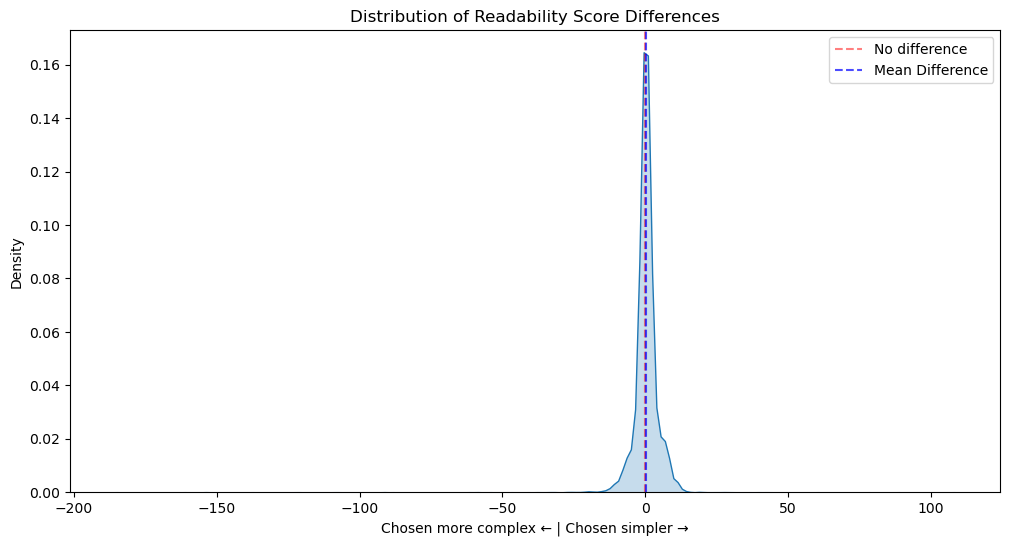

In [15]:
# Extract readability scores
chosen_readability = [textstat.dale_chall_readability_score(get_final_response(row['chosen'])) 
                      if len(get_final_response(row['chosen']).strip().split()) >= 0 else None 
                      for row in train_data]
rejected_readability = [textstat.dale_chall_readability_score(get_final_response(row['rejected']))
                        if len(get_final_response(row['rejected']).strip().split()) >= 0 else None 
                        for row in train_data]

# Remove None values and ties
valid_indices = [i for i in range(len(chosen_readability)) 
                if chosen_readability[i] is not None 
                and rejected_readability[i] is not None 
                and chosen_readability[i] != rejected_readability[i]]
chosen_readability = [chosen_readability[i] for i in valid_indices]
rejected_readability = [rejected_readability[i] for i in valid_indices]

total_pairs = len(chosen_readability)

# Count readability comparisons
chosen_more_complex = sum(c > r for c, r in zip(chosen_readability, rejected_readability))
rejected_more_complex = sum(c < r for c, r in zip(chosen_readability, rejected_readability))

total_valid_comparisons = chosen_more_complex + rejected_more_complex

# Binomial test
result = binomtest(rejected_more_complex, total_valid_comparisons, p=0.5)

# Calculate differences and effect size
differences = np.array(chosen_readability) - np.array(rejected_readability)
cohens_d = np.mean(differences) / np.std(differences) if np.std(differences) != 0 else 0

# Wilcoxon test
stat, p_value_wilcoxon = wilcoxon(chosen_readability, rejected_readability)

# --- Results ---
print("## Readability Complexity Hypothesis Test Results")

print(f"**Total Choices Analyzed:** {total_pairs}")
print(f"**Valid Comparisons (Unequal Readability Scores):** {total_valid_comparisons}")
print(f"**Times More Complex Response Was Chosen:** {chosen_more_complex} ({chosen_more_complex / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times More Complex Response Was Chosen:** {chosen_more_complex} (N/A)")
print(f"**Times Less Complex Response Was Chosen:** {rejected_more_complex} ({rejected_more_complex / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times Less Complex Response Was Chosen:** {rejected_more_complex} (N/A)")

print("\n### Binomial Test (Primary Test)")
print("**H0: Evaluators choose the simpler response 50% of the time**")
print("**H1: Evaluators prefer the simpler response (>50% of the time)**")

if result.pvalue < 0.05:
    print(f"**Result: REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    if rejected_more_complex > chosen_more_complex:
        print("**Conclusion: There is statistically significant evidence that evaluators prefer simpler responses.**")
    else:
        print("**Conclusion: There is statistically significant evidence AGAINST simplicity preference. Evaluators tend to prefer more complex responses.**")

    effect_size_interpretation = ""
    if abs(cohens_d) < 0.2:
        effect_size_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"
    print(f"**Effect Size (Cohen's d): {cohens_d:.3f} ({effect_size_interpretation}).**")

else:
    print(f"**Result: FAIL TO REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    print("**Conclusion: There is no statistically significant evidence that evaluators prefer more complex responses.**")

# Wilcoxon Test (Supplementary Information)
print("\n### Wilcoxon Signed-Rank Test (Supplementary)")
print("**This test examines the magnitude of readability differences, not choice probability directly.**")
if p_value_wilcoxon < 0.05:
    print(f"**Result: Statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the readability difference between chosen and rejected options is meaningful.**")
else:
    print(f"**Result: Not statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that readability complexity differences are not strongly associated with choices.**")

# Visualization of differences
plt.figure(figsize=(12, 6))
sns.kdeplot(data=differences, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='No difference')
plt.axvline(x=np.mean(differences), color='b', linestyle='--', alpha=0.7, label='Mean Difference')
plt.title('Distribution of Readability Score Differences')
plt.xlabel('Chosen more complex ← | Chosen simpler →')
plt.ylabel('Density')
plt.legend()
plt.show()


## Results
Out of 43,363 valid comparisons (excluding equal strength pairs):
- 53.7% chose the more complex (higher readability score) option
- 46.3% chose the less complex (lower readability score) option

### Statistical Tests
**Binomial Test**: Rejected H0 (p < 0.0001)  
**Interpretation**: Strong evidence that evaluators prefer more linguistically complex responses.

### Effect Size
Cohen's d = 0.049 (negligible practical effect)

### Key Result
Clear preference for more complex responses found (53.7% vs 46.3%), though effect size is negligible.

# Negativity Bias

The Negativity Bias literature posits that more negative statements will be percieved as more credible than more positive statements. 

Thus, the question follows:

<b>Do RLHF evaluators have a bias towards more negative responses?

In order to test this successfully, we will compare the sentiment of the chosen responses vs those that were not chosen. Importantly, we will only be looking at the final response in each entry, as this is the one that RLHF evaluators were asked to choose between. 

Here, we will be comparing the sentiment (calculated by VADER) between the chosen and rejected groups of the HH dataset. 


## Negativity Bias Hypothesis Test Results
**Total Choices Analyzed:** 43835
**Valid Comparisons (Unequal Sentiment):** 40984
**Times More Negative Option Was Chosen:** 18469 (45.1%)
**Times More Positive Option Was Chosen:** 22515 (54.9%)
**Equal Sentiment Choices:** 2851 (6.5%)

### Binomial Test (Primary Test)
**H0: Evaluators choose the more negative option 50% of the time**
**H1: Evaluators prefer the more negative option (>50% of the time)**
**Result: REJECT NULL HYPOTHESIS (p = 0.0000)**
**Conclusion: There is statistically significant evidence AGAINST a negativity bias. Evaluators tend to avoid the more negative option.**
**Effect Size (Cohen's d): 0.093 (negligible).**

### Wilcoxon Signed-Rank Test (Supplementary)
**This test examines the magnitude of sentiment differences, not choice probability directly.**
**Result: Statistically significant (p = 0.0000). This suggests that the magnitude of the negativity difference between chosen and rejected options is meaningful.**


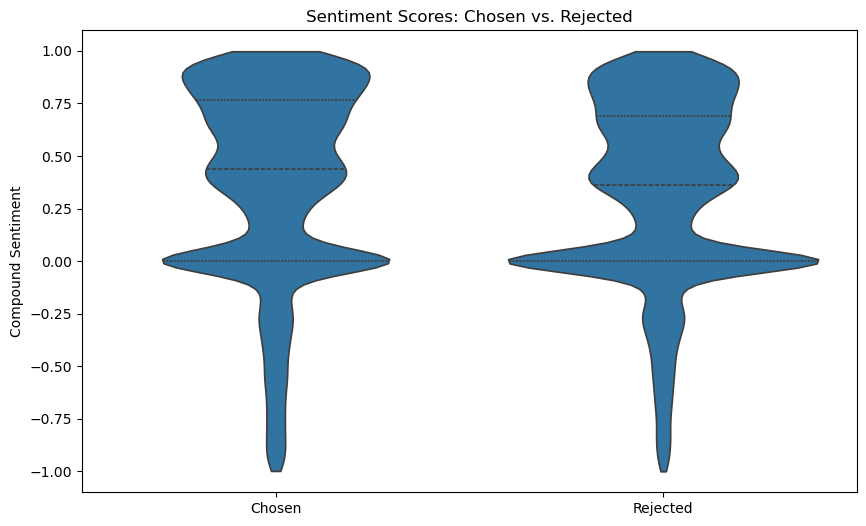

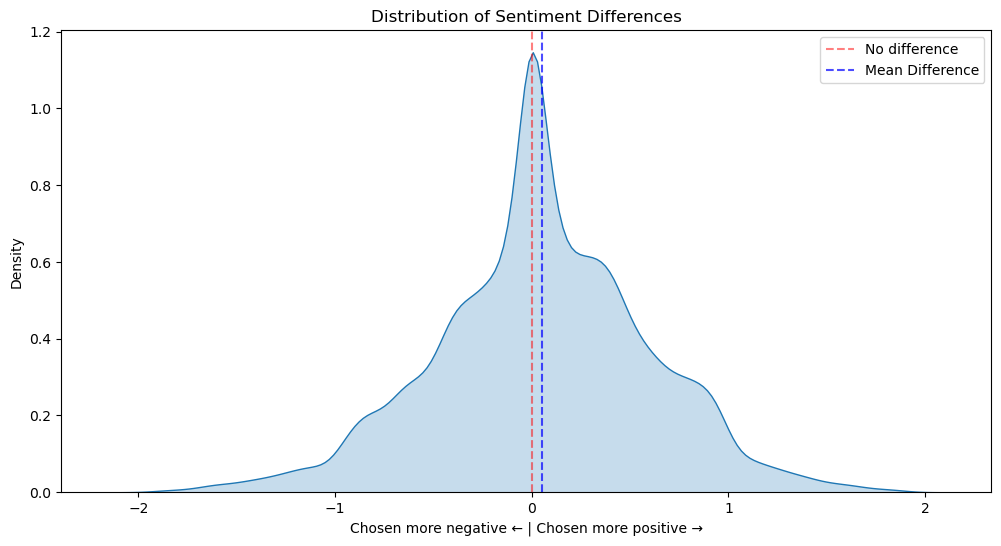

In [18]:
vader = SentimentIntensityAnalyzer()

# Calculate sentiments
chosen_sentiments = [vader.polarity_scores(get_final_response(row['chosen']))['compound']
                    for row in train_data]
rejected_sentiments = [vader.polarity_scores(get_final_response(row['rejected']))['compound']
                     for row in train_data]

# For each pair, count when the MORE negative option was chosen
total_pairs = len(chosen_sentiments)
# If chosen sentiment is lower (more negative) than rejected, they chose the more negative option
times_chose_more_negative = sum(1 for c, r in zip(chosen_sentiments, rejected_sentiments) 
                               if c < r)  
equal_sentiment = sum(c == r for c, r in zip(chosen_sentiments, rejected_sentiments))
times_chose_more_positive = sum(1 for c, r in zip(chosen_sentiments, rejected_sentiments) 
                               if c > r)

total_valid_comparisons = total_pairs - equal_sentiment

# Test if people tend to choose the more negative option (>50% of time)
result = binomtest(times_chose_more_negative, total_valid_comparisons, p=0.5)

# Calculate differences and effect size
differences = np.array(chosen_sentiments) - np.array(rejected_sentiments)
cohens_d = np.mean(differences) / np.std(differences) if np.std(differences) !=0 else 0

# Wilcoxon test
stat, p_value_wilcoxon = wilcoxon(chosen_sentiments, rejected_sentiments)

# --- Results ---
print("## Negativity Bias Hypothesis Test Results")

print(f"**Total Choices Analyzed:** {total_pairs}")
print(f"**Valid Comparisons (Unequal Sentiment):** {total_valid_comparisons}")
print(f"**Times More Negative Option Was Chosen:** {times_chose_more_negative} ({times_chose_more_negative / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times More Negative Option Was Chosen:** {times_chose_more_negative} (N/A)")
print(f"**Times More Positive Option Was Chosen:** {times_chose_more_positive} ({times_chose_more_positive / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times More Positive Option Was Chosen:** {times_chose_more_positive} (N/A)")
print(f"**Equal Sentiment Choices:** {equal_sentiment} ({equal_sentiment / total_pairs * 100:.1f}%)")

print("\n### Binomial Test (Primary Test)")
print(f"**H0: Evaluators choose the more negative option 50% of the time**")
print(f"**H1: Evaluators prefer the more negative option (>50% of the time)**")

if result.pvalue < 0.05:
    print(f"**Result: REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    if times_chose_more_negative > times_chose_more_positive:
        print("**Conclusion: There is statistically significant evidence of a negativity bias. Evaluators tend to choose the more negative option.**")
    else:
        print("**Conclusion: There is statistically significant evidence AGAINST a negativity bias. Evaluators tend to avoid the more negative option.**")

    effect_size_interpretation = ""
    if abs(cohens_d) < 0.2:
        effect_size_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"
    print(f"**Effect Size (Cohen's d): {cohens_d:.3f} ({effect_size_interpretation}).**")

else:
    print(f"**Result: FAIL TO REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    print("**Conclusion: There is no statistically significant evidence of a negativity bias.**")

# Wilcoxon Test (Supplementary Information)
print("\n### Wilcoxon Signed-Rank Test (Supplementary)")
print("**This test examines the magnitude of sentiment differences, not choice probability directly.**")
if p_value_wilcoxon < 0.05:
    print(f"**Result: Statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of the negativity difference between chosen and rejected options is meaningful.**")
else:
    print(f"**Result: Not statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of the negativity difference is not strongly associated with the choices made.**")

# Violin Plot of chosen vs. rejected sentiments
plt.figure(figsize=(10, 6))
sns.violinplot(x=['Chosen'] * len(chosen_sentiments) + ['Rejected'] * len(rejected_sentiments),
             y=chosen_sentiments + rejected_sentiments,
             inner="quartile",
             cut=0)
plt.title('Sentiment Scores: Chosen vs. Rejected')
plt.ylabel('Compound Sentiment')
plt.show()

# Visualization of differences
plt.figure(figsize=(12, 6))
sns.kdeplot(data=differences, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='No difference')
plt.axvline(x=np.mean(differences), color='b', linestyle='--', alpha=0.7, label='Mean Difference')
plt.title('Distribution of Sentiment Differences')
plt.xlabel('Chosen more negative ← | Chosen more positive →')
plt.ylabel('Density')
plt.legend()
plt.show()

## Results

Out of 40,984 valid comparisons (excluding equal sentiment pairs):
* 54.9% chose more positive option
* 45.1% chose more negative option

### Statistical Tests
**Binomial Test**: Rejected H0 (p < 0.0001)  
**Interpretation**: Strong evidence that evaluators avoid more negative responses.

### Effect Size
Cohen's d = 0.093 (negligible practical effect)

### Key Result
Clear preference <b>against</b> negative sentiment found (54.9% vs 45.1%), though effect size is negligible.

# Emotionality

The Emotionality literature posits that more intense sentiment statements will be percieved as more credible than more positive statements. 

Thus, the question follows:

<b>Do RLHF evaluators have a bias towards responses with a stronger sentiment? </b>

In order to test this successfully, we will compare the sentiment strength of the chosen responses vs those that were not chosen. Importantly, we will only be looking at the final response in each entry, as this is the one that RLHF evaluators were asked to choose between. 

Evaluating sentiment intensity bias will be relatively similar to the process we used in negativity bias. We will again use VADER, but use a folder measure of sentiment. Since we only care about sentiment intensity, this means we will be ignoring the  sign (positive or negative) of the senitment that VADER calculates, and will instead be focusing on how high the sentiment is (again, irrespective of how negative or positive is).



## Sentiment Strength Analysis Results
**Total Choices Analyzed:** 43835
**Valid Comparisons (Unequal Strength):** 40947
**Times Stronger Option Chosen:** 23307 (56.9%)
**Times Weaker Option Chosen:** 17640 (43.1%)
**Equal Strength Choices:** 2888 (6.6%)

### Binomial Test (Primary Test)
**H0: Evaluators choose stronger sentiment option 50% of the time**
**H1: Evaluators prefer stronger sentiment option (>50% of the time)**
**Result: REJECT NULL HYPOTHESIS (p = 0.0000)**
**Conclusion: There is statistically significant evidence that evaluators prefer stronger sentiment.**
**Effect Size (Cohen's d): 0.156 (negligible).**


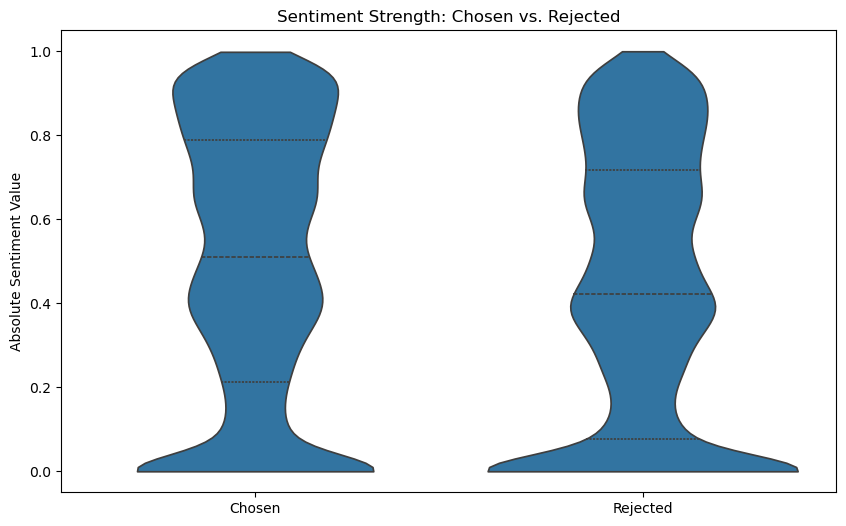

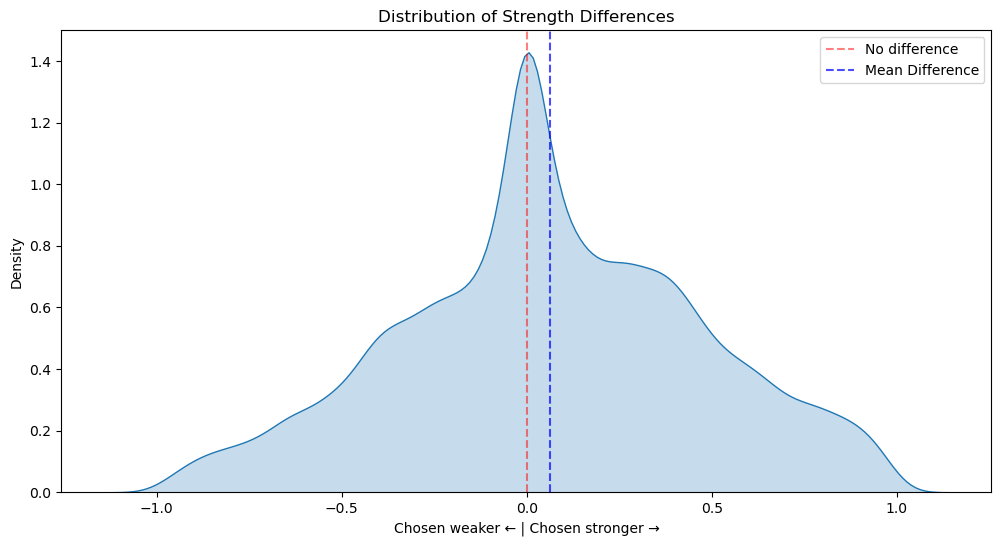

In [21]:
vader = SentimentIntensityAnalyzer()

# Calculate sentiments and strengths
chosen_sentiments = [vader.polarity_scores(get_final_response(row['chosen']))['compound']
                   for row in train_data]
rejected_sentiments = [vader.polarity_scores(get_final_response(row['rejected']))['compound']
                    for row in train_data]

# Calculate absolute values for sentiment strength
chosen_strengths = [abs(s) for s in chosen_sentiments]
rejected_strengths = [abs(s) for s in rejected_sentiments]

# Count preferences
total_pairs = len(chosen_strengths)
times_chose_stronger = sum(1 for c, r in zip(chosen_strengths, rejected_strengths) 
                         if c > r)
equal_strength = sum(c == r for c, r in zip(chosen_strengths, rejected_strengths))
times_chose_weaker = sum(1 for c, r in zip(chosen_strengths, rejected_strengths) 
                       if c < r)

total_valid_comparisons = total_pairs - equal_strength

# Binomial test for strength preference
result = binomtest(times_chose_stronger, total_valid_comparisons, p=0.5)

# Effect size
strength_differences = np.array(chosen_strengths) - np.array(rejected_strengths)
cohens_d = np.mean(strength_differences) / np.std(strength_differences) if np.std(strength_differences) != 0 else 0

# Wilcoxon test
stat, p_value_wilcoxon = wilcoxon(chosen_strengths, rejected_strengths)

# Results
print("## Sentiment Strength Analysis Results")
print(f"**Total Choices Analyzed:** {total_pairs}")
print(f"**Valid Comparisons (Unequal Strength):** {total_valid_comparisons}")
print(f"**Times Stronger Option Chosen:** {times_chose_stronger} ({times_chose_stronger/total_valid_comparisons*100:.1f}%)")
print(f"**Times Weaker Option Chosen:** {times_chose_weaker} ({times_chose_weaker/total_valid_comparisons*100:.1f}%)")
print(f"**Equal Strength Choices:** {equal_strength} ({equal_strength/total_pairs*100:.1f}%)")

print("\n### Binomial Test (Primary Test)")
print(f"**H0: Evaluators choose stronger sentiment option 50% of the time**")
print(f"**H1: Evaluators prefer stronger sentiment option (>50% of the time)**")

if result.pvalue < 0.05:
   print(f"**Result: REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
   if times_chose_stronger > times_chose_weaker:
       print("**Conclusion: There is statistically significant evidence that evaluators prefer stronger sentiment.**")
   else:
       print("**Conclusion: There is statistically significant evidence that evaluators avoid stronger sentiment.**")

   effect_size_interpretation = ""
   if abs(cohens_d) < 0.2:
       effect_size_interpretation = "negligible"
   elif abs(cohens_d) < 0.5:
       effect_size_interpretation = "small"
   elif abs(cohens_d) < 0.8:
       effect_size_interpretation = "medium"
   else:
       effect_size_interpretation = "large"
   print(f"**Effect Size (Cohen's d): {cohens_d:.3f} ({effect_size_interpretation}).**")
else:
   print(f"**Result: FAIL TO REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
   print("**Conclusion: No significant preference for sentiment strength.**")

# Visualizations
plt.figure(figsize=(10, 6))
sns.violinplot(x=['Chosen'] * len(chosen_strengths) + ['Rejected'] * len(rejected_strengths),
            y=chosen_strengths + rejected_strengths,
            inner="quartile",
            cut=0)
plt.title('Sentiment Strength: Chosen vs. Rejected')
plt.ylabel('Absolute Sentiment Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=strength_differences, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='No difference')
plt.axvline(x=np.mean(strength_differences), color='b', linestyle='--', alpha=0.7, label='Mean Difference')
plt.title('Distribution of Strength Differences')
plt.xlabel('Chosen weaker ← | Chosen stronger →')
plt.ylabel('Density')
plt.legend()
plt.show()

## Results
Out of 40,947 valid comparisons (excluding equal strength pairs):
- 56.9% chose stronger sentiment option
- 43.1% chose weaker sentiment option

### Statistical Tests
**Binomial Test**: Rejected H0 (p < 0.0001)  
**Interpretation**: Strong evidence that evaluators prefer responses with stronger sentiment intensity.

### Effect Size
Cohen's d = 0.156 (negligible practical effect)

### Key Result
Clear preference for stronger sentiment found (56.9% vs 43.1%), though effect size is negligible.

# Conflicting Sentiment bias

The literature posits that responses with the highest sentiment conflict (i.e., the most difference with the previous responses' sentiment)  will be perceived as least credible than those which have a lower sentiment conflict. 

Thus, the question follows:

<b>Do RLHF evaluators have a bias towards responses with less conflicting sentiments? </b>

Our final bias, conflicting sentiment bias, will also be evaluated using the VADER library for sentiment analysis. Since we are trying to see how a different sentiment in the response choice relative to the previous responses the evaluator was presented with affected their choice, this method will involve calculating the sentiment of the final response, and every response before that separately. Then, we will subtract these to find what we will call the **sentiment conflict**. Finally, we will compare the sentiment conflict between chosen and rejected responses, to see if evaluators systematically preferred one over the other.  


## Sentiment Conflict Hypothesis Test Results
**Total Choices Analyzed:** 43835
**Valid Comparisons (Unequal Conflict):** 40988
**Times Lower Conflict Option Was Chosen:** 20947 (51.1%)
**Times Higher Conflict Option Was Chosen:** 20041 (48.9%)
**Equal Conflict Choices:** 2847 (6.5%)

### Binomial Test (Primary Test)
**H0: Evaluators choose the lower conflict option 50% of the time**
**H1: Evaluators prefer the lower conflict option (>50% of the time)**
**Result: REJECT NULL HYPOTHESIS (p = 0.0000)**
**Conclusion: There is statistically significant evidence that evaluators prefer lower sentiment conflict. Evaluators tend to choose options with less sentiment conflict.**
**Effect Size (Cohen's d): -0.024 (negligible).**

### Wilcoxon Signed-Rank Test (Supplementary)
**This test examines the magnitude of sentiment conflict differences, not choice probability directly.**
**Result: Statistically significant (p = 0.0000). This suggests that the magnitude of sentiment conflict difference bet

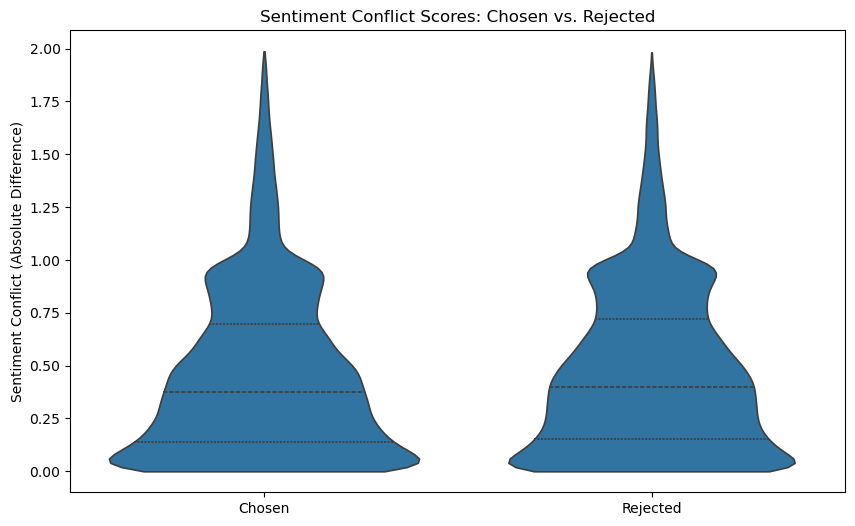

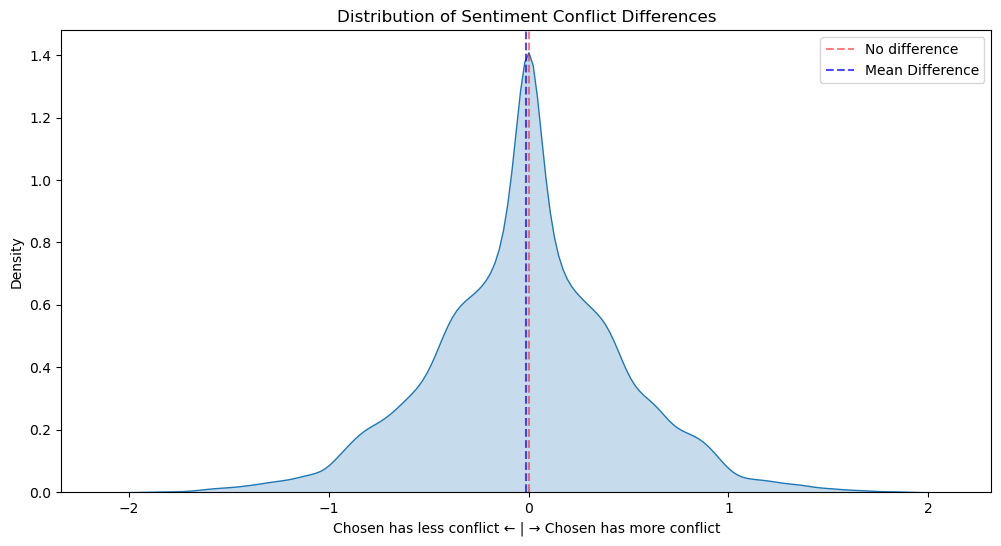

In [24]:
# Function to get all content except final assistant response
def get_all_but_final_response(text):
    """Extract all conversation content except the final assistant response."""
    parts = text.split('Assistant:')
    return 'Assistant:'.join(parts[:-1]).strip()
vader = SentimentIntensityAnalyzer()

# Calculate sentiment conflicts
chosen_sentiment_diff = []
rejected_sentiment_diff = []

for row in train_data:
    # Calculate sentiment differences for chosen and rejected responses
    chosen_text = row['chosen']
    rejected_text = row['rejected']
    
    # Sentiment for the full conversation (all but final)
    sentiment_all_but_final_chosen = vader.polarity_scores(get_all_but_final_response(chosen_text))['compound']
    sentiment_all_but_final_rejected = vader.polarity_scores(get_all_but_final_response(rejected_text))['compound']
    
    # Sentiment for the final response
    sentiment_final_chosen = vader.polarity_scores(get_final_response(chosen_text))['compound']
    sentiment_final_rejected = vader.polarity_scores(get_final_response(rejected_text))['compound']
    
    # Calculate absolute sentiment difference: |final - all-but-final|
    chosen_diff = abs(sentiment_final_chosen - sentiment_all_but_final_chosen)
    rejected_diff = abs(sentiment_final_rejected - sentiment_all_but_final_rejected)
    
    chosen_sentiment_diff.append(chosen_diff)
    rejected_sentiment_diff.append(rejected_diff)

# For each pair, count when the option with LESS sentiment conflict was chosen
total_pairs = len(chosen_sentiment_diff)
times_chose_less_conflict = sum(1 for c, r in zip(chosen_sentiment_diff, rejected_sentiment_diff) 
                               if c < r)  # Changed to c < r to count when chosen has less conflict
equal_conflict = sum(c == r for c, r in zip(chosen_sentiment_diff, rejected_sentiment_diff))
times_chose_more_conflict = sum(1 for c, r in zip(chosen_sentiment_diff, rejected_sentiment_diff) 
                               if c > r)

total_valid_comparisons = total_pairs - equal_conflict

# Test if people tend to choose the option with less sentiment conflict (>50% of time)
result = binomtest(times_chose_less_conflict, total_valid_comparisons, p=0.5)

# Calculate differences and effect size
differences = np.array(chosen_sentiment_diff) - np.array(rejected_sentiment_diff)
cohens_d = np.mean(differences) / np.std(differences) if np.std(differences) != 0 else 0

# Wilcoxon test
stat, p_value_wilcoxon = wilcoxon(chosen_sentiment_diff, rejected_sentiment_diff)

# --- Results ---
print("## Sentiment Conflict Hypothesis Test Results")

print(f"**Total Choices Analyzed:** {total_pairs}")
print(f"**Valid Comparisons (Unequal Conflict):** {total_valid_comparisons}")
print(f"**Times Lower Conflict Option Was Chosen:** {times_chose_less_conflict} ({times_chose_less_conflict / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times Lower Conflict Option Was Chosen:** {times_chose_less_conflict} (N/A)")
print(f"**Times Higher Conflict Option Was Chosen:** {times_chose_more_conflict} ({times_chose_more_conflict / total_valid_comparisons * 100:.1f}%)" if total_valid_comparisons != 0 else f"**Times Higher Conflict Option Was Chosen:** {times_chose_more_conflict} (N/A)")
print(f"**Equal Conflict Choices:** {equal_conflict} ({equal_conflict / total_pairs * 100:.1f}%)")

print("\n### Binomial Test (Primary Test)")
print(f"**H0: Evaluators choose the lower conflict option 50% of the time**")
print(f"**H1: Evaluators prefer the lower conflict option (>50% of the time)**")

if result.pvalue < 0.05:
    print(f"**Result: REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    if times_chose_less_conflict > times_chose_more_conflict:
        print("**Conclusion: There is statistically significant evidence that evaluators prefer lower sentiment conflict. Evaluators tend to choose options with less sentiment conflict.**")
    else:
        print("**Conclusion: There is statistically significant evidence AGAINST the hypothesis. Evaluators tend to choose options with higher sentiment conflict.**")

    effect_size_interpretation = ""
    if abs(cohens_d) < 0.2:
        effect_size_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_size_interpretation = "medium"
    else:
        effect_size_interpretation = "large"
    print(f"**Effect Size (Cohen's d): {cohens_d:.3f} ({effect_size_interpretation}).**")

else:
    print(f"**Result: FAIL TO REJECT NULL HYPOTHESIS (p = {result.pvalue:.4f})**")
    print("**Conclusion: There is no statistically significant evidence that evaluators prefer responses with lower sentiment conflict.**")

# Wilcoxon Test (Supplementary Information)
print("\n### Wilcoxon Signed-Rank Test (Supplementary)")
print("**This test examines the magnitude of sentiment conflict differences, not choice probability directly.**")
if p_value_wilcoxon < 0.05:
    print(f"**Result: Statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of sentiment conflict difference between chosen and rejected options is meaningful.**")
else:
    print(f"**Result: Not statistically significant (p = {p_value_wilcoxon:.4f}). This suggests that the magnitude of sentiment conflict difference is not strongly associated with the choices made.**")

# Violin Plot of chosen vs. rejected sentiment conflicts
plt.figure(figsize=(10, 6))
sns.violinplot(x=['Chosen'] * len(chosen_sentiment_diff) + ['Rejected'] * len(rejected_sentiment_diff),
             y=chosen_sentiment_diff + rejected_sentiment_diff,
             inner="quartile",
             cut=0)
plt.title('Sentiment Conflict Scores: Chosen vs. Rejected')
plt.ylabel('Sentiment Conflict (Absolute Difference)')
plt.show()

# Visualization of differences
plt.figure(figsize=(12, 6))
sns.kdeplot(data=differences, fill=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='No difference')
plt.axvline(x=np.mean(differences), color='b', linestyle='--', alpha=0.7, label='Mean Difference')
plt.title('Distribution of Sentiment Conflict Differences')
plt.xlabel('Chosen has less conflict ← | → Chosen has more conflict')
plt.ylabel('Density')
plt.legend()
plt.show()

## Results
Out of 43,835 valid comparisons (excluding equal strength pairs):
- 51.1%% chose the lower sentiment conflict option
- 48.9% chose the less complex (lower readability score) option

### Statistical Tests
**Binomial Test**: Rejected H0 (p < 0.0001)  
**Interpretation**: Strong evidence that evaluators prefer responses with a lower sentiment conflict between the final response and prior interactions.

### Effect Size
Cohen's d = -0.024 (negligible practical effect)

### Key Result
Clear preference for more less sentiment conflict (51.1% vs 48.9%), though effect size is negligible.

# Discussion

Let's go ahead and put these all on a table to have an overview of what we found:

| Bias Type | Evidence Found? | Direction | Chosen % | Effect Size (Cohen's d) |
|:----------|:---------------|:----------|----------:|:------------------------|
| Length | Yes | Prefer Longer | 59.2% | 0.216 (small) |
| Negativity | Yes | Avoid Negative | 54.9% | 0.093 (negligible) |
| Sentiment Strength | Yes | Prefer Stronger | 56.9% | 0.156 (negligible) |
| Readability Complexity | Yes | Prefer Complex | 53.7% | 0.049 (negligible) |
| Sentiment Conflict | Yes | Prefer Lower Conflict | 51.1% | -0.024 (negligible) |


## What is going on here?

We found evidence for almost every bias in the literature (with the exception of negativity bias, which we found a bias in the opposite direction), **though the effect sizes are so small, they are almost negligible!** 
    
So why could this be? Initially, when I first looked at the data, I was shocked. Considering the wide amount of literature suggesting these congitive biases exist, I expected at least one of them would have a stronger effect or would be shown at a greater scale than they were. 

After a lot of pondering (and double-checking my code) I came to the following question:

Since we're looking at <b>differences</b> in these attributes, are the choices participants are presented with so similar in their sentiment, length and readability that our ability to audit for these biases is limited? 

Let's go ahead and test this by plotting the distribution of sentiment, reading complexity and word length in the dataset below. Importantly, rather than plotting rejected and chosen attributes separately, **I will be sampling randomly to create two groups whose distributions we can plot. this allows us to see how different the attributes are irrespective of whether they were chosen or not.** 




### Length distribution

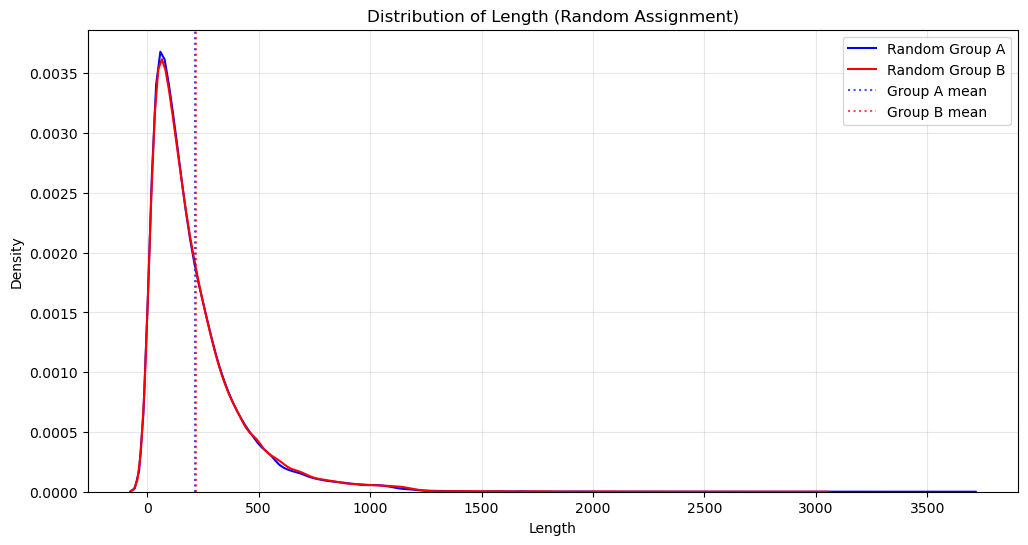

Mean length - Random Group A: 213.061
Mean length - Random Group B: 217.007


In [28]:
# Create random assignment
random_chosen_lens = []
random_rejected_lens = []

# For each pair, randomly assign one length to "chosen" and the other to "rejected"
for c, r in zip(chosen_lens, rejected_lens):
    if np.random.random() < 0.5:
        random_chosen_lens.append(c)
        random_rejected_lens.append(r)
    else:
        random_chosen_lens.append(r)
        random_rejected_lens.append(c)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot density curves for random assignments
sns.kdeplot(data=random_chosen_lens, fill=False, label='Random Group A', color='blue')
sns.kdeplot(data=random_rejected_lens, fill=False, label='Random Group B', color='red')

# Add vertical line at mean
plt.axvline(x=np.mean(random_chosen_lens), color='blue', linestyle=':', alpha=0.7, label='Group A mean')
plt.axvline(x=np.mean(random_rejected_lens), color='red', linestyle=':', alpha=0.7, label='Group B mean')

# Customize plot
plt.title('Distribution of Length (Random Assignment)')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# Print mean values for reference
print(f"Mean length - Random Group A: {np.mean(random_chosen_lens):.3f}")
print(f"Mean length - Random Group B: {np.mean(random_rejected_lens):.3f}")

### Sentiment distribution 

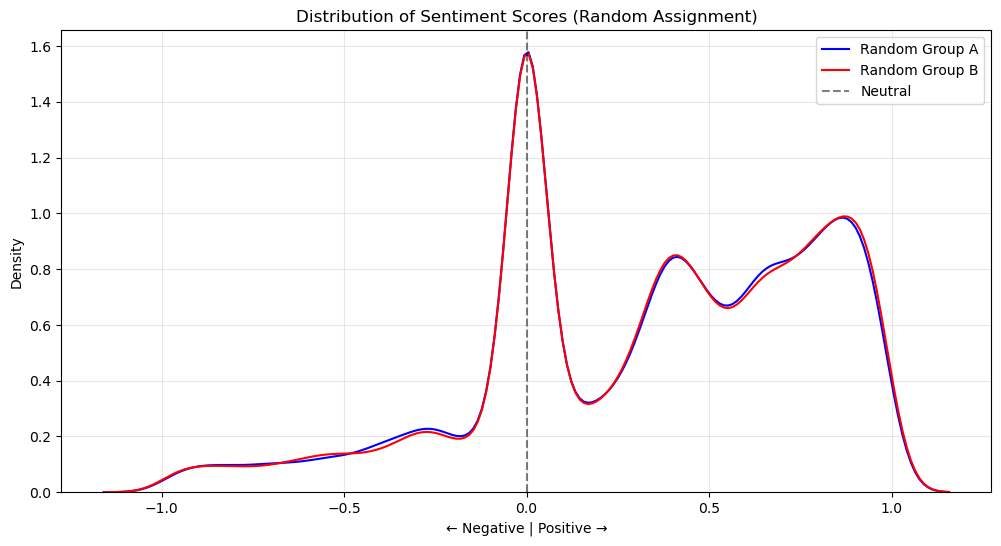

Mean sentiment - Random Group A: 0.336
Mean sentiment - Random Group B: 0.341


In [30]:
# Create random assignment
random_chosen = []
random_rejected = []

# For each pair, randomly assign one sentiment to "chosen" and the other to "rejected"
for c, r in zip(chosen_sentiments, rejected_sentiments):
    if np.random.random() < 0.5:
        random_chosen.append(c)
        random_rejected.append(r)
    else:
        random_chosen.append(r)
        random_rejected.append(c)

# Plot both the actual and random distributions
plt.figure(figsize=(12, 6))

# Plot random assignment
sns.kdeplot(data=random_chosen, label='Random Group A', color='blue')
sns.kdeplot(data=random_rejected, label='Random Group B', color='red')

# Add vertical line at 0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Neutral')

plt.title('Distribution of Sentiment Scores (Random Assignment)')
plt.xlabel('← Negative | Positive →')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# Print means for reference
print(f"Mean sentiment - Random Group A: {np.mean(random_chosen):.3f}")
print(f"Mean sentiment - Random Group B: {np.mean(random_rejected):.3f}")

### Readabiility score distribution

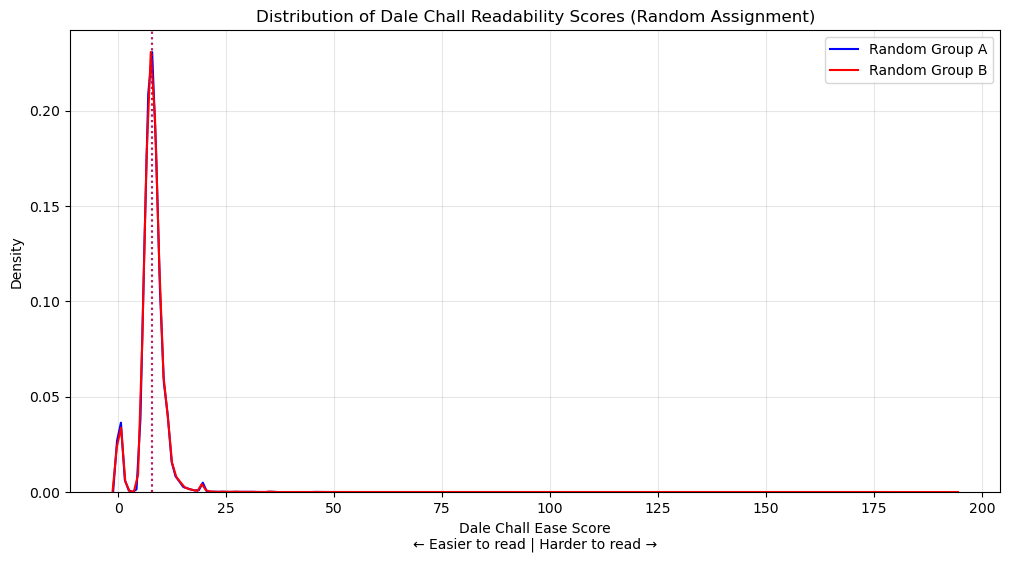

Mean readability - Random Group A: 7.807
Mean readability - Random Group B: 7.851


In [32]:
# Extract readability scores
chosen_readability = [textstat.dale_chall_readability_score(get_final_response(row['chosen'])) 
                      if len(get_final_response(row['chosen']).strip().split()) >= 0 else None 
                      for row in train_data]
rejected_readability = [textstat.dale_chall_readability_score(get_final_response(row['rejected']))
                        if len(get_final_response(row['rejected']).strip().split()) >= 0 else None 
                        for row in train_data]

# Create random assignment (including None values)
random_group_a = []
random_group_b = []

# For each pair, randomly assign scores to groups
for c, r in zip(chosen_readability, rejected_readability):
    if np.random.random() < 0.5:
        random_group_a.append(c)
        random_group_b.append(r)
    else:
        random_group_a.append(r)
        random_group_b.append(c)

# Create visualization
plt.figure(figsize=(12, 6))

# Remove None values just for plotting
random_group_a_clean = [x for x in random_group_a if x is not None]
random_group_b_clean = [x for x in random_group_b if x is not None]

# Plot density curves for random assignments
sns.kdeplot(data=random_group_a_clean, fill=False, label='Random Group A', color='blue')
sns.kdeplot(data=random_group_b_clean, fill=False, label='Random Group B', color='red')

# Customize plot
plt.title('Distribution of Dale Chall Readability Scores (Random Assignment)')
plt.xlabel('Dale Chall Ease Score\n← Easier to read | Harder to read →')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Show means with vertical lines
plt.axvline(x=np.mean(random_group_a_clean), color='blue', linestyle=':', alpha=0.7, label='Group A mean')
plt.axvline(x=np.mean(random_group_b_clean), color='red', linestyle=':', alpha=0.7, label='Group B mean')

plt.show()

# Print mean values for reference
print(f"Mean readability - Random Group A: {np.mean(random_group_a_clean):.3f}")
print(f"Mean readability - Random Group B: {np.mean(random_group_b_clean):.3f}")


# Homogeneity in Sentiment, Length, and Reading Complexity across choices

Aha! That makes sense. 

In the distributions above, we see that when randomly sampling for each pair of chosen vs not chosen, and plotting the distributions of these two random groups, we see nearly identical distributions of sentiment, readability score, and length! Essentially, a <b>potential reason</b> why we may have only found small effects in those results we found is because the choices participants are presented with are almost identical in their sentiment, length, and readability! 


## What does this tell us about the RLHF process?

The apparent homogeneity in surface-level features across RLHF training pairs raises significant questions about the efficacy of Reinforcement Learning from Human Feedback. When evaluators are presented with responses that share nearly identical sentiment, length, and readability metrics, we might inadvertently mask or eliminate important dimensions of variation that could be crucial for training truly helpful AI Assistants. The rigid similarity between options could be creating a form of artificial constraint that doesn't reflect the full spectrum of what constitutes genuinely helpful or harmful responses in real-world interactions.

Furthermore, this observation points to a deeper methodological concern about how we're approaching the challenge of AI alignment through RLHF. By presenting evaluators with such closely matched pairs, we might be implicitly encoding certain assumptions about what constitutes a helpful response, potentially missing important edge cases or alternative approaches. The focus on maintaining similar surface-level characteristics across training pairs could be leading to a form of training myopia, where models learn to optimize for a artificially constrained version of helpfulness rather than developing more robust and flexible understanding of truly helpful behavior.


# So what? - Concluding Remarks

Our analysis has revealed two critical findings that have significant implications for how we approach RLHF and AI alignment more broadly:

## 1. Systematic Biases Exist, But Not As Expected

Our investigation revealed consistent biases in evaluator choices, though not always in the directions predicted by cognitive/behavioural science literature:

- Length Bias: Strong preference for longer responses (59.2%)
- Sentiment: Unexpected preference against negative responses (54.9%)
- Sentiment Strength: Preference for stronger sentiment (56.9%)
- Readability: Preference for more complex responses (53.7%)
- Sentiment Conflict: Slight preference for lower conflict (51.1%)

However, the most striking aspect isn't the presence of these biases, but their surprisingly **small effect sizes**. This leads us to our second, and perhaps more significant finding.

## 2. The Homogeneity Problem

The minimal effect sizes point towards a fundamental characteristic of the choice pairs: they're remarkably similar in their surface-level features. Our random sampling analysis revealed nearly identical distributions of sentiment, length, and readability between options. This homogeneity has profound implications for RLHF methodology.

## Implications for AI Alignment

These findings raise several concerns about current RLHF implementations:

1. **Training Myopia**: The high similarity between choice pairs may be creating an artificially narrow conception of "helpfulness." We might be training models to optimize for a pre-determined version of helpful behavior rather than developing a robust understanding of true helpfulness accross these attributes.

2. **Hidden Constraints**: The standardization of surface-level features across choices suggests we may be inadvertently encoding implicit constraints about what constitutes a "valid" response. This could be limiting the model's exploration of potentially valuable response strategies.

3. **Measurement Challenge**: If choices are too similar, we might be forcing evaluators to make distinctions based on subtle differences that don't meaningfully reflect true preferences about helpfulness.

## Moving Forward: Recommendations

Based on these findings, there are several directions we could look towards to potentially improve RLHF methodology:

1. **Diversify Choice Pairs**: Deliberately introduce more variation in surface-level features between options to better understand how these characteristics influence helpfulness judgments.

2. **Expand Evaluation Metrics**: Move beyond binary choices to capture more nuanced preferences and allow evaluators to articulate why certain responses are more helpful.

3. **Context-Aware Sampling**: Develop methods for generating choice pairs that maintain meaningful differences while remaining contextually appropriate.

## Future Research Directions

This work opens several important avenues for future research:

1. Investigation into optimal levels of variation between choice pairs
2. Exploration of how different types of response diversity affect model learning
3. A more nuanced, and in-depth behavioural analysis testing for more heuristics

## Caveats

There are several flaws in this investigation that are important to note. On a technical level, there are several confounding variables which, had they been considered, could have made the analysis much more in depth. These mainly have to do with the **content** of the responses, which was something that wasn't actually looked at or controlled for when conducting these analyses. In an ideal world, this, alongside other important variables such as respondent fatigue would have to be controlled for in these analyses. Moreover, the technical measures of sentiment and complexity, while very reliable, are by no means SOTA (State of the Art). In (another) ideal world, these analysis would be conducted with more advanced models, such as a transformer sentiment model. 

## Conclusion

Our findings suggest current implementations of RLHF may be more constrained than previously recognized. The combination of subtle biases and high choice pair homogeneity indicates we may need to rethink how we generate and present options for human evaluation. Understanding these limitations is crucial for developing more effective preference learning methods and, ultimately, better aligned AI systems.

The path forward likely involves balancing the need for comparable choices with the importance of capturing the full spectrum of helpful behavior. Only by addressing these challenges can we ensure RLHF truly captures human preferences rather than just surface-level approximations. Inevitably, achieving this will require a greater collaboration between the developers of these methodologies, and experts on sciences relating to human behaviour. 